In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Read the data from the parquet file
df = pd.read_parquet('../../data/set-a.parquet')

display(df)


Time   Age  BUN  Creatinine   GCS  Gender  Glucose  HCO3   HCT  \
0       00:00  54.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   
1       01:00  54.0  NaN         NaN  15.0     0.0      NaN   NaN   NaN   
2       02:00  54.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   
3       03:00  54.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   
4       04:00  54.0  NaN         NaN  15.0     0.0      NaN   NaN  33.7   
...       ...   ...  ...         ...   ...     ...      ...   ...   ...   
195995  44:00  78.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   
195996  45:00  78.0  NaN         NaN  15.0     0.0      NaN   NaN   NaN   
195997  46:00  78.0  NaN         NaN  14.0     0.0      NaN   NaN   NaN   
195998  47:00  78.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   
195999  48:00  78.0  NaN         NaN   NaN     0.0      NaN   NaN   NaN   

           HR  ...   MAP  MechVent  PaCO2   PaO2    pH  SaO2  SysABP  \
0         NaN  ...   NaN       NaN    NaN    NaN   NaN   NaN     NaN   
1        75.0  ...   NaN       NaN    NaN    NaN   NaN   NaN     NaN   
2        60.0  ...   NaN       NaN    NaN    NaN   NaN   NaN     NaN   
3        62.0  ...   NaN       NaN    NaN    NaN   NaN   NaN     NaN   
4        80.0  ...   NaN       NaN    NaN    NaN   NaN   NaN     NaN   
...       ...  ...   ...       ...    ...    ...   ...   ...     ...   
195995  103.0  ...  75.0       NaN   40.0  122.0  7.34  98.0   112.0   
195996   87.0  ...  71.5       NaN    NaN    NaN   NaN   NaN   110.0   
195997   85.0  ...  73.0       NaN    NaN    NaN  7.31   NaN   112.0   
195998   86.0  ...  80.0       NaN    NaN    NaN   NaN   NaN   121.0   
195999   85.0  ...  85.0       NaN    NaN    NaN   NaN   NaN   128.0   

        TroponinI  TroponinT  Weight(static)  
0             NaN        NaN             NaN  
1             NaN        NaN             NaN  
2             NaN        NaN             NaN  
3             NaN        NaN             NaN  
4             NaN        NaN             NaN  
...           ...        ...             ...  
195995        NaN        NaN            70.7  
195996        NaN        NaN            70.7  
195997        NaN        NaN            70.7  
195998        NaN        NaN            70.7  
195999        NaN        NaN            70.7  

[196000 rows x 44 columns]

In [3]:
# Calculate the fraction of patients with at least one measurement for each variable
patients_with_measurement = df.groupby("RecordID").apply(lambda group: group.notnull().any()).mean() * 100
patients_with_measurement = patients_with_measurement.sort_values(ascending=False)

# Create a table of features and their fractions of patients with measurements
measurement_table = pd.DataFrame({
    "Feature": patients_with_measurement.index,
    "Fraction of Patients with Measurements (%)": patients_with_measurement.values
})

# Display the sorted table of missing fractions
measurement_table

Feature  Fraction of Patients with Measurements (%)
0             Time                                     100.000
1              Age                                     100.000
2          ICUType                                     100.000
3         RecordID                                     100.000
4           Gender                                      99.925
5               HR                                      98.425
6       Creatinine                                      98.400
7              BUN                                      98.400
8              HCT                                      98.400
9              GCS                                      98.400
10            Temp                                      98.400
11       Platelets                                      98.300
12             WBC                                      98.175
13              Na                                      98.125
14            HCO3                                      98.100
15               K                                      97.600
16              Mg                                      97.425
17         Glucose                                      97.175
18           Urine                                      97.075
19          Weight                                      92.600
20  Weight(static)                                      91.850
21        NISysABP                                      87.325
22       NIDiasABP                                      87.075
23           NIMAP                                      87.025
24              pH                                      76.000
25            PaO2                                      75.575
26           PaCO2                                      75.575
27         DiasABP                                      69.975
28          SysABP                                      69.975
29             MAP                                      69.800
30            FiO2                                      67.925
31        MechVent                                      63.225
32         Lactate                                      54.575
33          Height                                      52.650
34            SaO2                                      44.800
35             AST                                      43.125
36             ALT                                      43.025
37       Bilirubin                                      42.950
38             ALP                                      42.250
39         Albumin                                      40.375
40        RespRate                                      27.525
41       TroponinT                                      21.575
42     Cholesterol                                       7.625
43       TroponinI                                       5.125

Index(['Age', 'BUN', 'Creatinine', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT',
       'HR', 'Height', 'ICUType', 'K', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP',
       'Na', 'Platelets', 'RespRate', 'Temp', 'Urine', 'WBC', 'Weight',
       'Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'Cholesterol', 'FiO2',
       'DiasABP', 'Lactate', 'MAP', 'MechVent', 'PaCO2', 'PaO2', 'pH', 'SaO2',
       'SysABP', 'TroponinI', 'TroponinT', 'Weight(static)'],
      dtype='object')


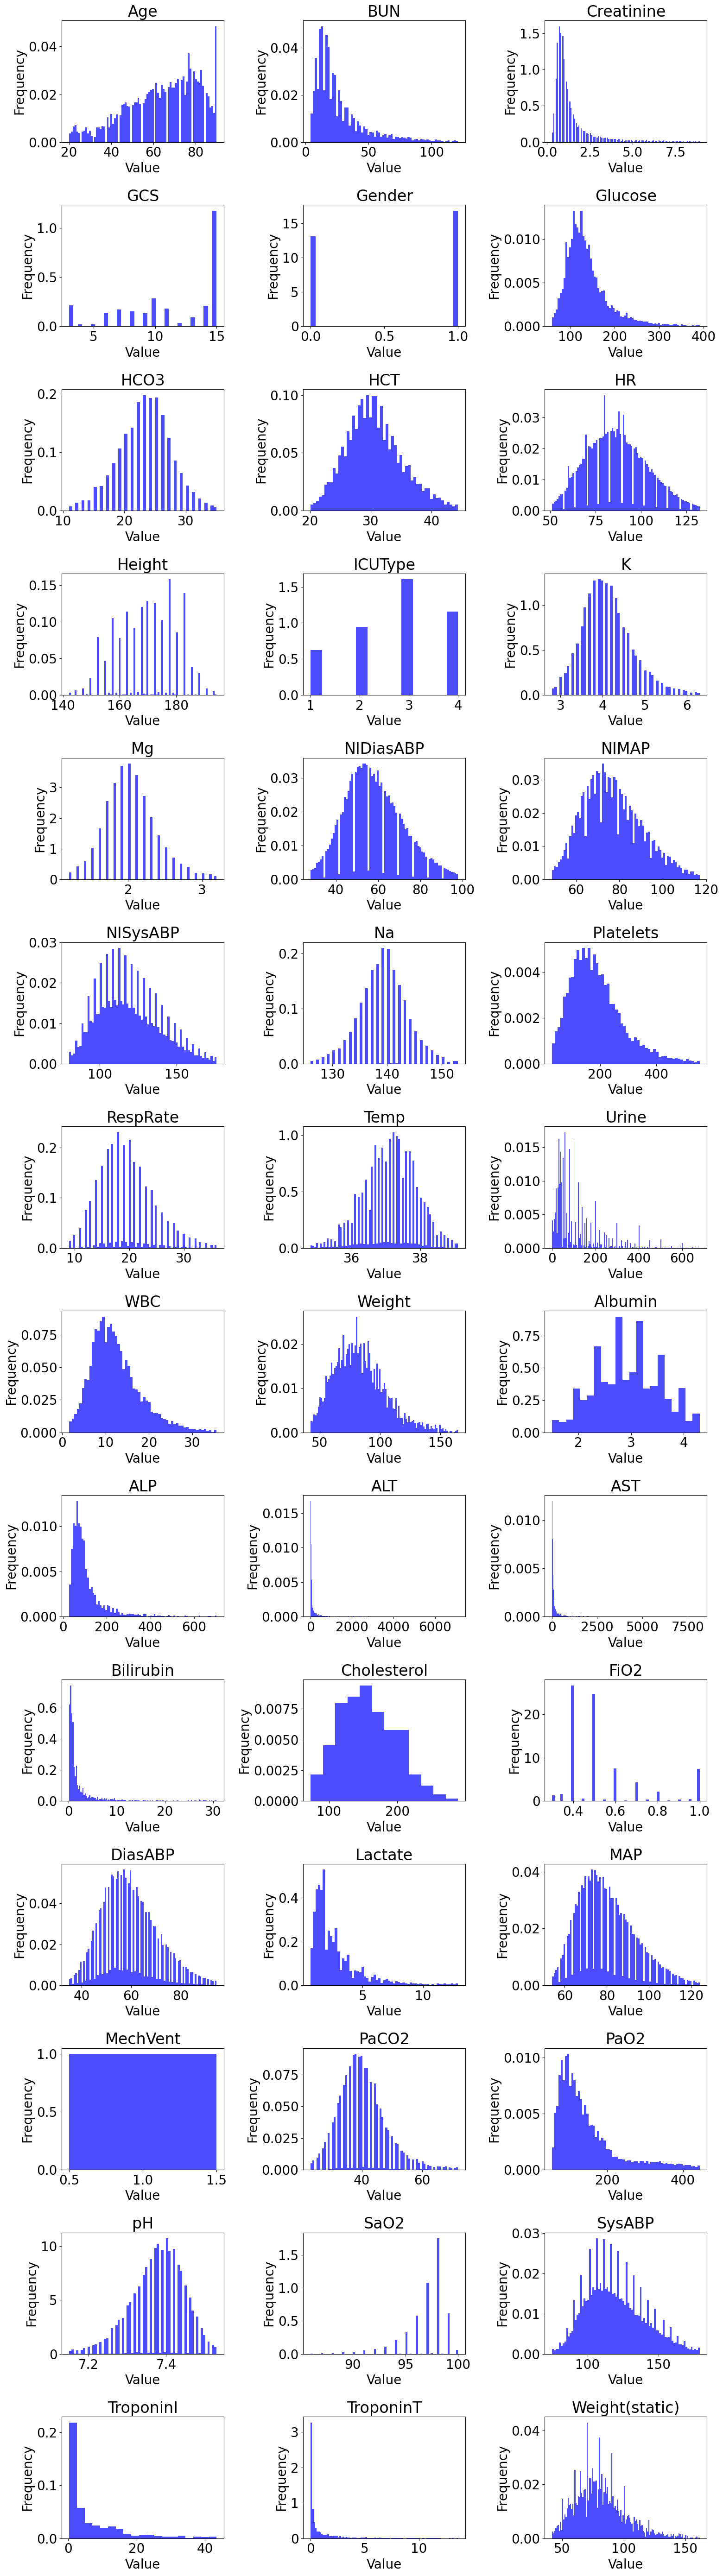

In [4]:
df_numerical = df.drop(columns=["RecordID", "Time"])

print(df_numerical.columns)


# Remove outliers
# Calculate the 1st and 99th percentiles for each numeric column
percentiles = df_numerical.quantile([0.01, 0.99])

# Filter each numeric column to keep only values within the 1st and 99th percentiles
for column in df_numerical.columns:
    lower_bound = percentiles.loc[0.01, column]
    upper_bound = percentiles.loc[0.99, column]
    df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), other=np.nan)

n_cols = 3  # Number of columns in the mosaic
n_rows = int(np.ceil(len(df_numerical.columns) / n_cols))  # Number of rows needed

plt.rcParams.update({'font.size': 20}) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(df_numerical.columns):
    ax = axes[i]
    ax.hist(df[column].dropna(), bins='auto', color='blue', alpha=0.7, density=True)
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



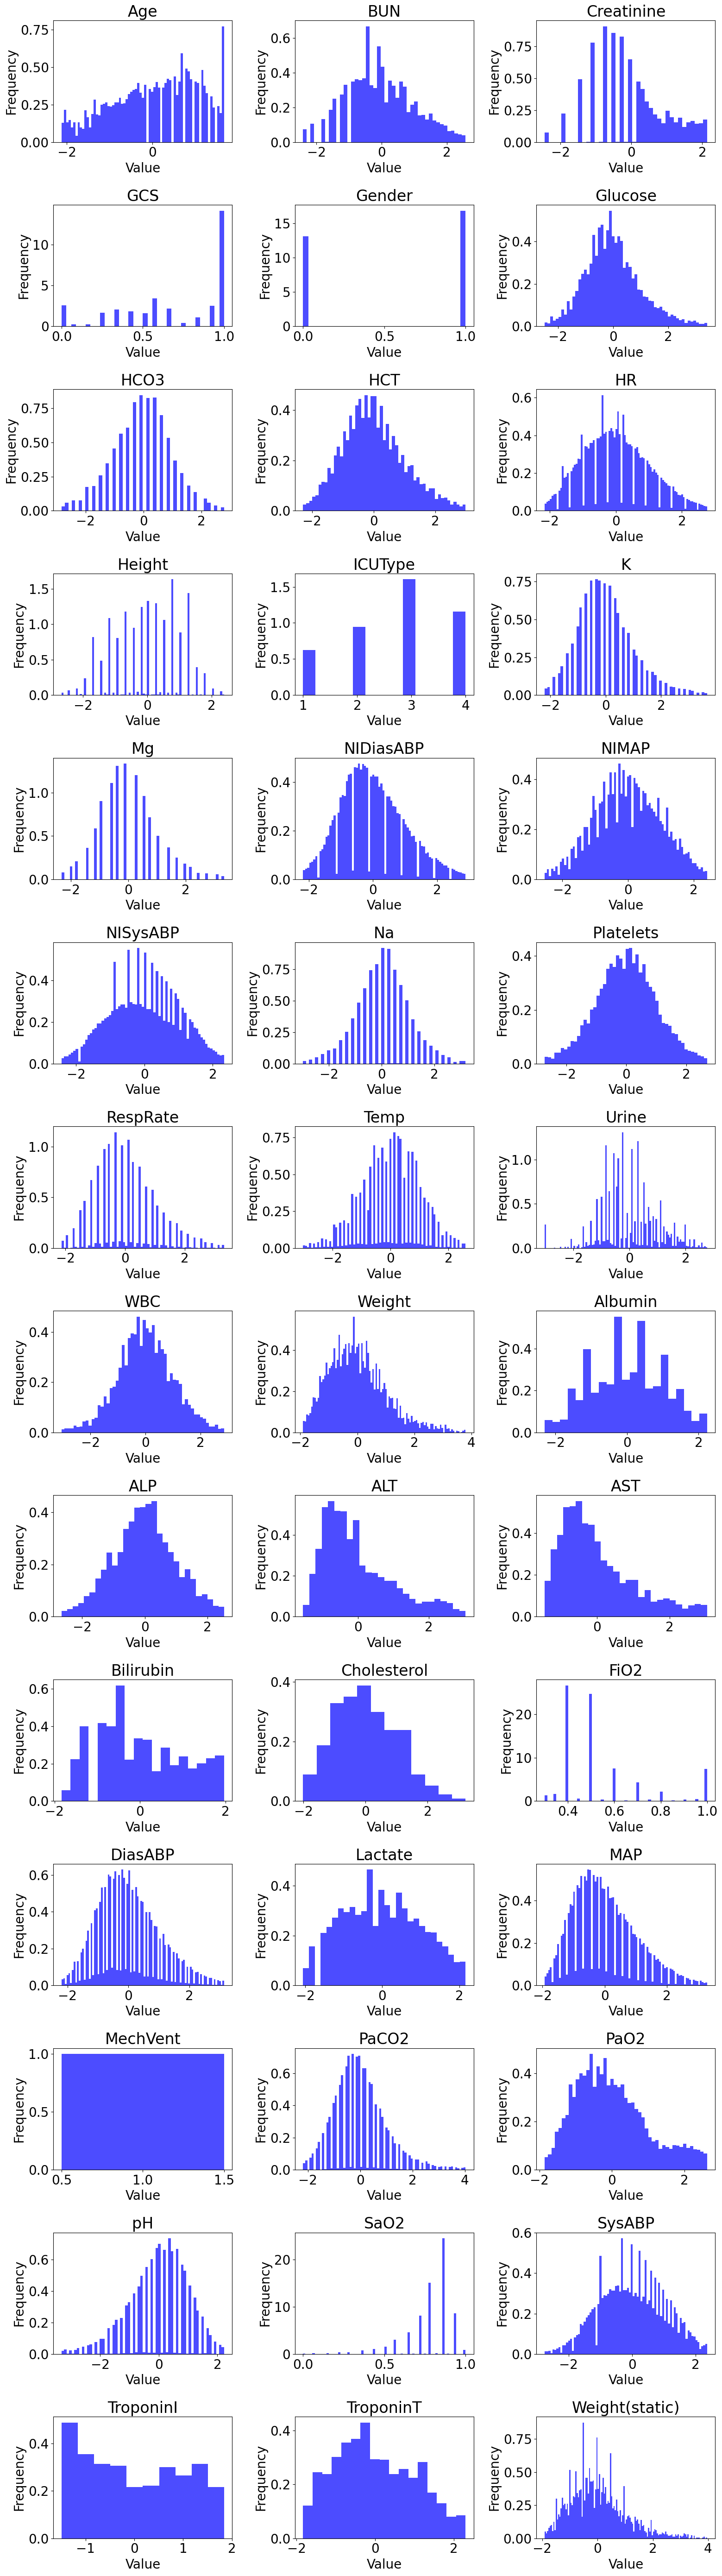

In [5]:
df_numerical = df.drop(columns=["RecordID", "Time"])

# Remove outliers
# Calculate the 1st and 99th percentiles for each numeric column

n_cols = 3  # Number of columns in the mosaic
n_rows = int(np.ceil(len(df_numerical.columns) / n_cols))  # Number of rows needed

plt.rcParams.update({'font.size': 20}) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(df_numerical.columns):
    if column not in ['RecordID', 'Time']:
        df_numerical[column] = df_numerical[column].mask(df[column] < 0, pd.NA)
        ax = axes[i]
        if column in ['Creatinine', 'Age', 'Urine', 'NIMAP', 'NISysABP', 'Platelets', 'WBC', 'ALP', 'Bilirubin', 'Lactate', 'SysABP', 'TroponinI']:
            df_numerical[column] = PowerTransformer(method='yeo-johnson').fit_transform(df_numerical[[column]])
        if column in ['BUN', 'Glucose', 'ALT', 'AST', 'PaO2', 'TroponinT']:
            df_numerical[column] = np.log(df[column])
            df_numerical[column] = StandardScaler().fit_transform(df_numerical[[column]]) 
        if column in ['GCS', 'SaO2']:
            df_numerical[column] = MinMaxScaler().fit_transform(df_numerical[[column]])
        if column in ['HCO3', 'HCT', 'HR', 'Height', 'K', 'Mg', 'NIDiasABP', 'Na', 'RespRate', 'Temp', 'Albumin', 'Cholesterol', 'DiasABP', 'MAP', 'PaCO2', 'pH', 'Weight', 'Weight(static)']:
            df_numerical[column] = StandardScaler().fit_transform(df_numerical[[column]])
        ax.hist(df_numerical[column], bins='auto', color='blue', alpha=0.7, density=True)
        ax.set_title(column)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


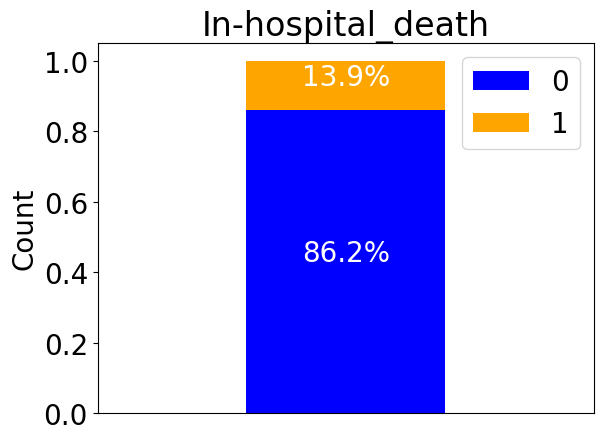

In [6]:
# Load data
labels_a = pd.read_csv('../../data/Outcomes-a.txt', sep=',')

# Count occurrences of 0 and 1 (normalized)
value_counts = labels_a['In-hospital_death'].value_counts(normalize=True)

# Create a stacked bar
plt.bar(0, value_counts[0], color='blue', label='0', width=0.4)  # Bottom part (0s)
plt.bar(0, value_counts[1], bottom=value_counts[0], color='orange', label='1', width=0.4)  # Top part (1s)

# Annotate percentages
plt.text(0, value_counts[0] / 2, f"{value_counts[0] * 100:.1f}%", ha='center', color='white')  # For 0
plt.text(0, value_counts[0] + value_counts[1] / 2, f"{value_counts[1] * 100:.1f}%", ha='center', color='white')  # For 1

# Formatting
plt.xticks([])  # Remove x-ticks since we have only one bar
plt.ylabel("Count")
plt.title("In-hospital_death")
plt.xlim(-0.5, 0.5)  # Center the single bar
plt.legend()
plt.show()

/tmp/ipykernel_133830/1795509224.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=column, hue="Gender", ax=ax, fill=True, alpha=0.4)
/tmp/ipykernel_133830/1795509224.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=column, hue="Gender", ax=ax, fill=True, alpha=0.4)


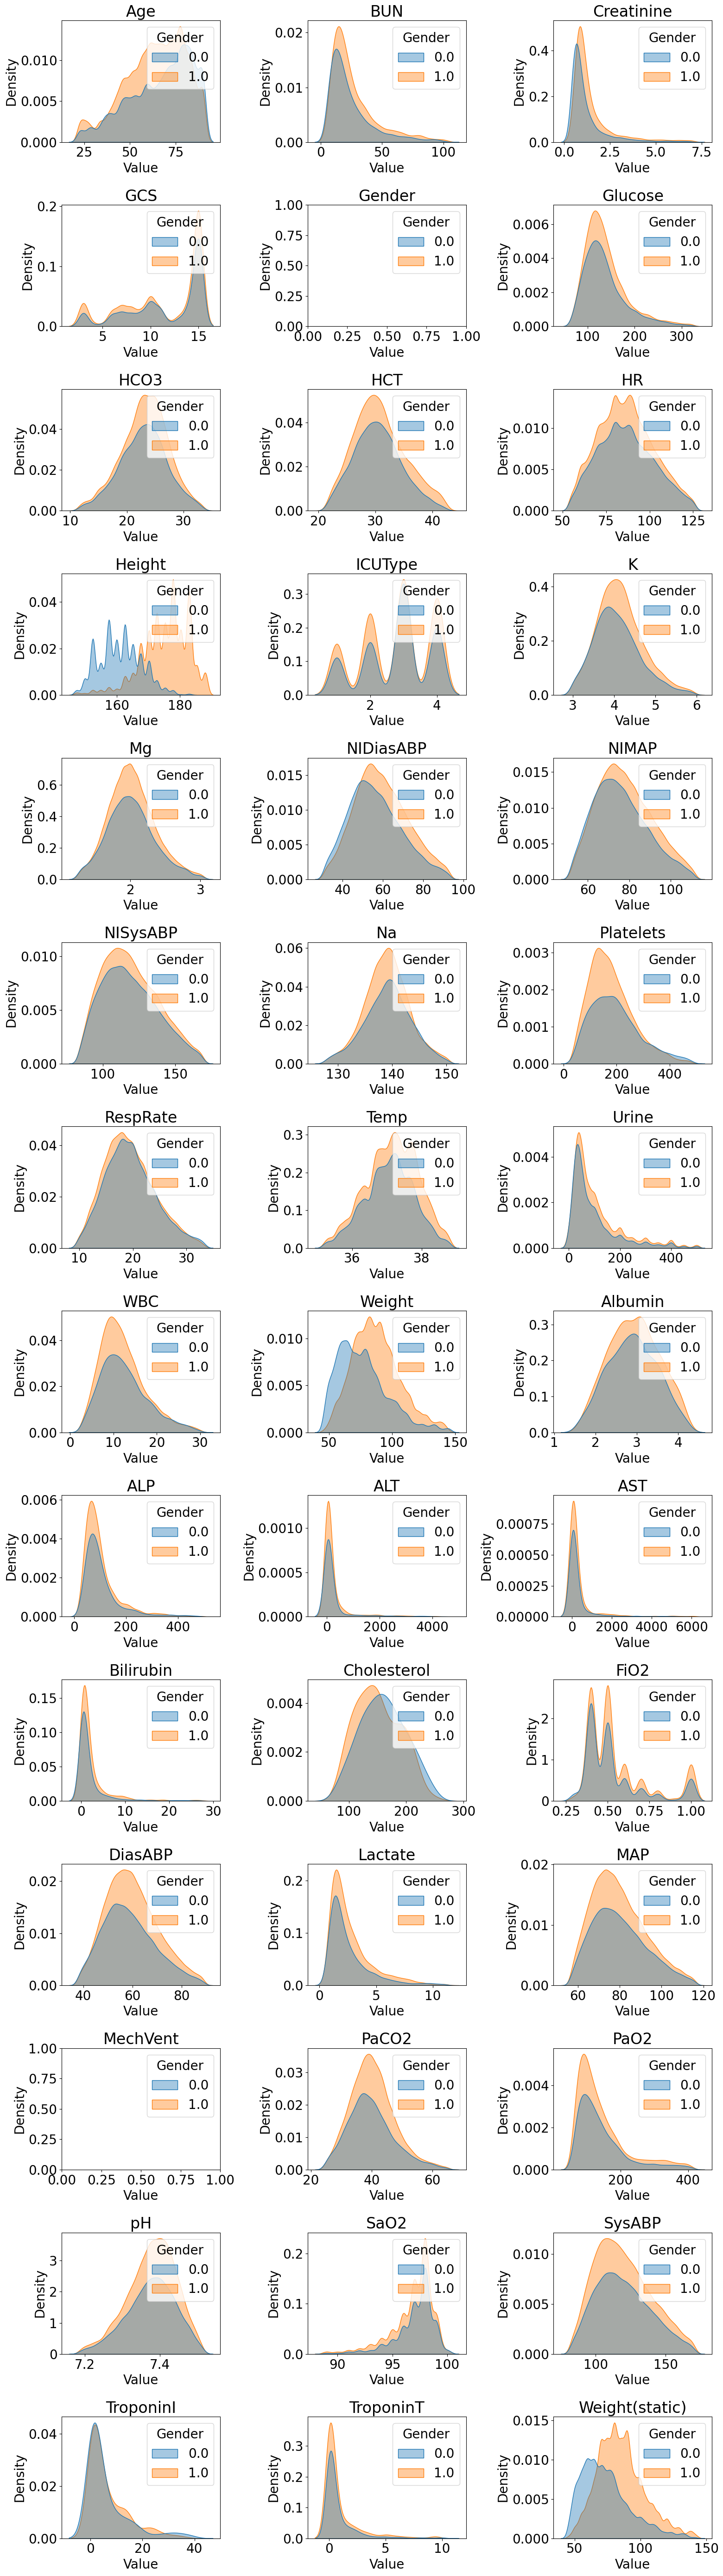

In [7]:
# Drop unwanted columns
df_numerical = df.drop(columns=["RecordID", "Time"])


# Remove outliers
percentiles = df_numerical.quantile([0.01, 0.99])

for column in df_numerical.columns:
    lower_bound = percentiles.loc[0.01, column]
    upper_bound = percentiles.loc[0.99, column]
    df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), other=np.nan)

# Map 0.0 and 1.0 in the Gender column to "Female" and "Male"
df_numerical["Gender"] = df_numerical["Gender"].map({0.0: "Female", 1.0: "Male"})


# Setting up subplots for density plots grouped by Gender
n_cols = 3  # Number of columns per row in the mosaic
n_rows = int(np.ceil(len(df_numerical.columns) / n_cols))  # Number of rows needed

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(df_numerical.columns):
    ax = axes[i]
    if column in df_numerical.columns:
        # Use seaborn for density plots grouped by Gender
        sns.kdeplot(data=df, x=column, hue="Gender", ax=ax, fill=True, alpha=0.4)
        ax.set_title(column)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_133830/2415118837.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/2415118837.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/2415118837.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/2415118837.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,


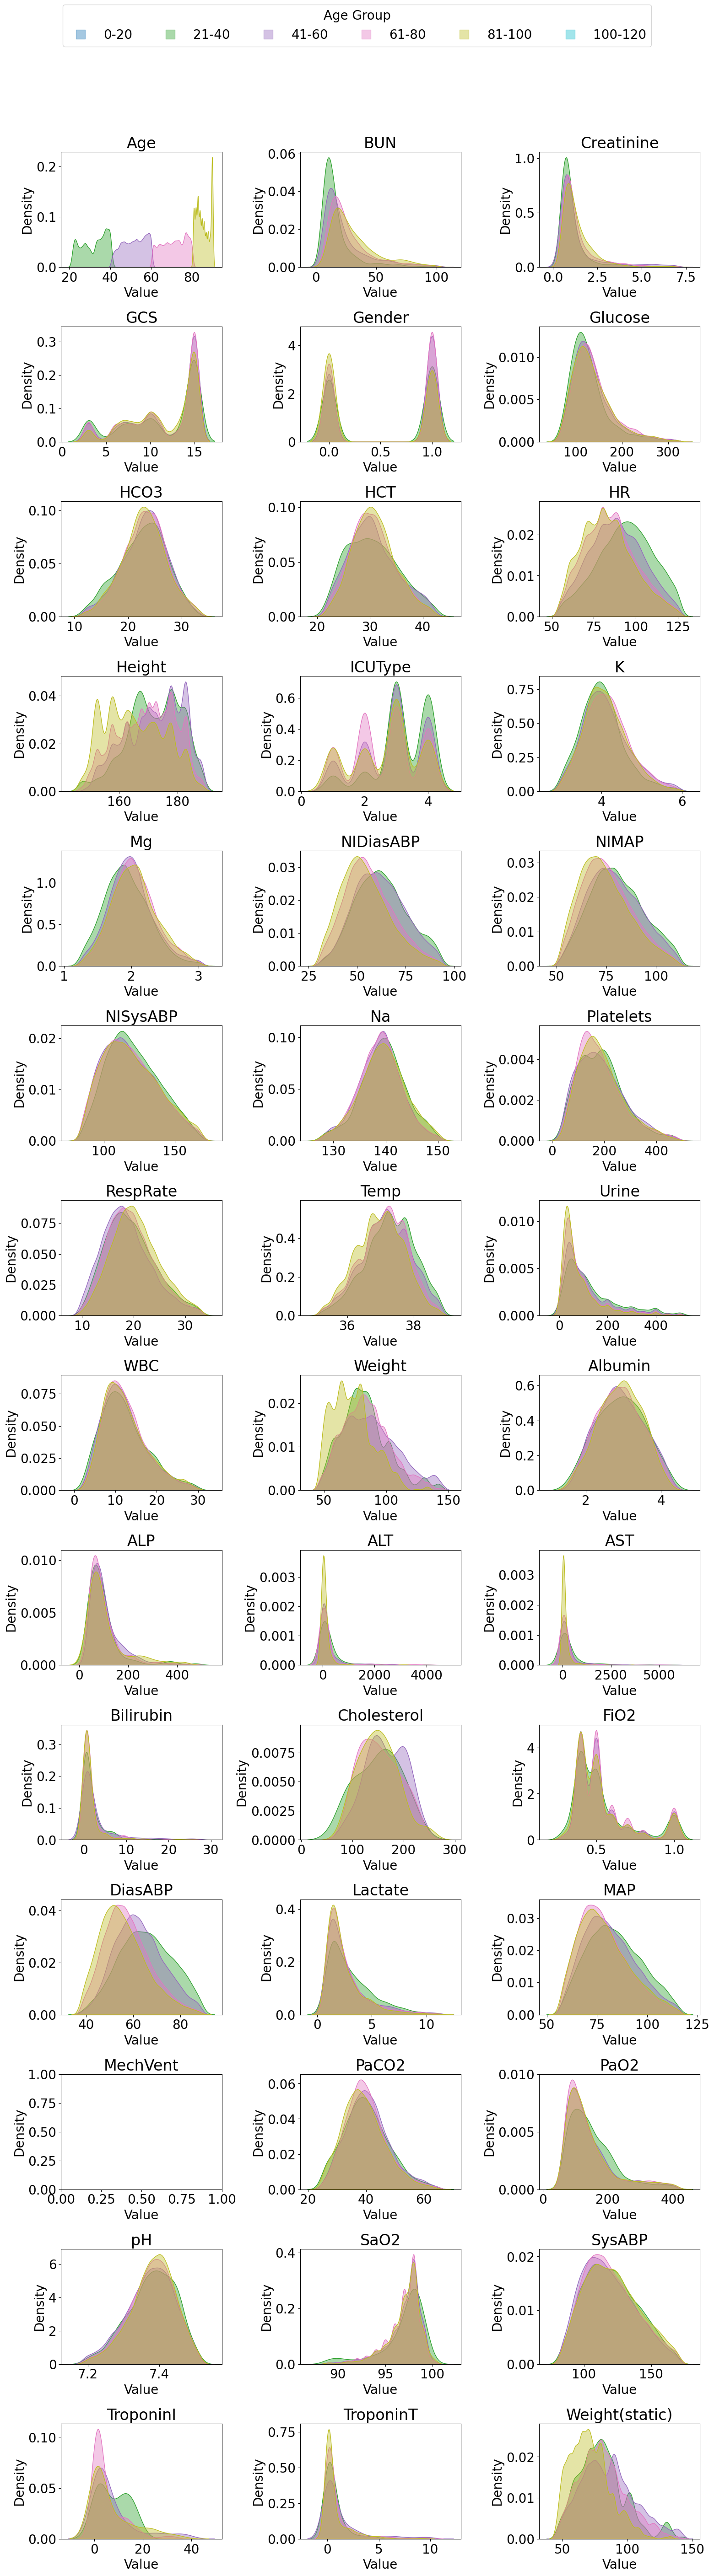

In [8]:
# Drop unwanted columns
df_numerical = df.drop(columns=["RecordID", "Time"])

# Remove outliers
percentiles = df_numerical.quantile([0.01, 0.99])
for column in df_numerical.columns:
    lower_bound = percentiles.loc[0.01, column]
    upper_bound = percentiles.loc[0.99, column]
    df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), other=np.nan)

# Define Age Groups
bins = [0, 20, 40, 60, 80, 100, 120]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '100-120']
df_numerical['Age Group'] = pd.cut(df_numerical['Age'], bins=bins, labels=labels)

# Setting up subplots for density plots grouped by Age Group
n_cols = 3  # Number of columns per row
n_features = len([col for col in df_numerical.columns if col != "Age Group"])  # Count numerical columns
n_rows = max(1, int(np.ceil(n_features / n_cols)))  # Ensure at least 1 row

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=False, sharey=False)
axes = axes.flatten()

plot_index = 0

# Instead of using dropna().unique() which might miss groups with no data,
# use the predefined labels to ensure all groups are represented
age_groups = labels  # Use the predefined labels instead of extracting from data
colors = plt.cm.tab10(np.linspace(0, 1, len(age_groups)))
custom_lines = []
custom_labels = []

for column in df_numerical.columns:
    if column != "Age Group":  # Avoid plotting the categorical column
        ax = axes[plot_index]
        
        # Plot each age group with consistent colors
        for i, age_group in enumerate(age_groups):
            subset = df_numerical[df_numerical['Age Group'] == age_group]
            
            # Only add to the custom legend elements on the first plot
            if plot_index == 0:
                # Create a color patch for the legend
                patch = plt.Line2D([0], [0], color=colors[i], lw=0, 
                                 marker='s', markersize=15, 
                                 markerfacecolor=colors[i], alpha=0.4)
                custom_lines.append(patch)
                custom_labels.append(age_group)
            
            # Only plot if subset has data
            if not subset.empty:
                sns.kdeplot(data=subset, x=column, ax=ax, 
                        color=colors[i], label=age_group, 
                        fill=True, alpha=0.4)
        
        ax.set_title(column)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        
        # Remove individual legends
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        
        plot_index += 1

# Remove unused subplots
for j in range(plot_index, len(axes)):
    fig.delaxes(axes[j])

# First apply tight layout to optimize the plot spacing
plt.tight_layout()

# Add a single legend outside the plot with minimal spacing from the top
fig.legend(custom_lines, custom_labels, 
          title="Age Group",
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.01),
          ncol=len(custom_labels),
          frameon=True)

# Adjust top margin - reduce this value to bring legend closer to plots
plt.subplots_adjust(top=0.95)

plt.show()

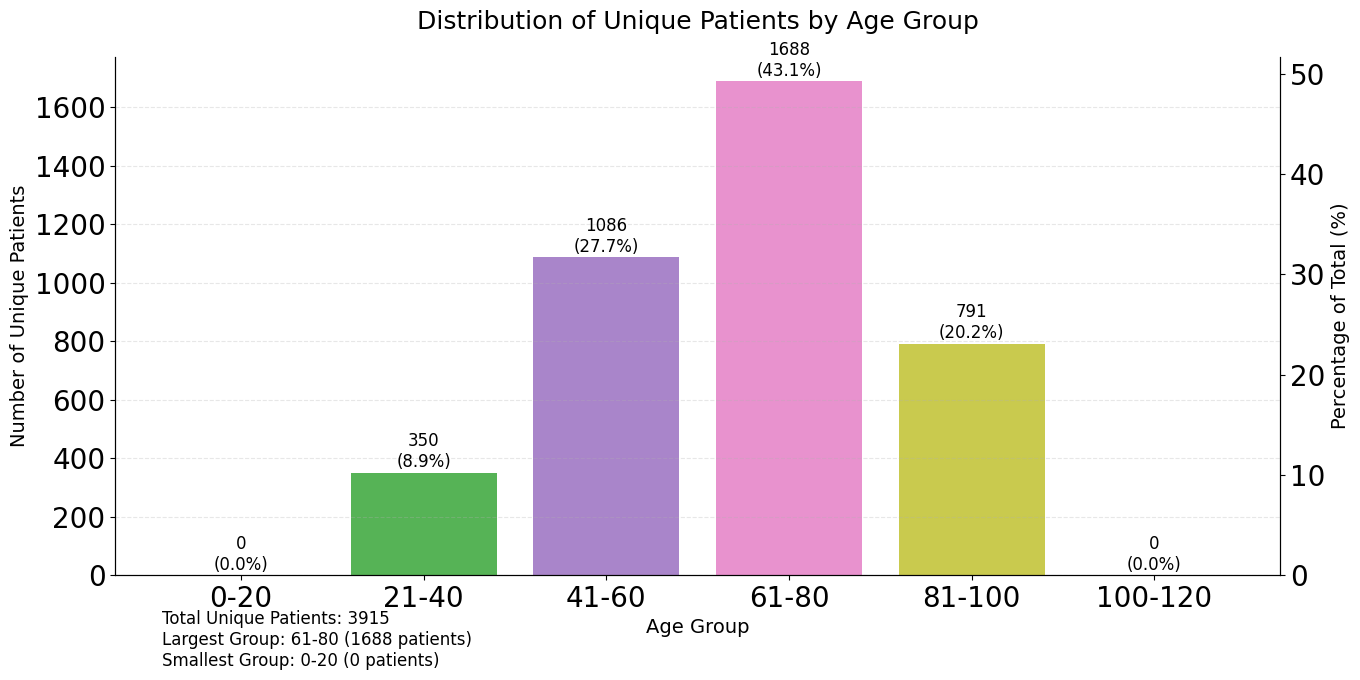


Age Group Distribution:


Count  Percentage (%)
Age Group                       
0-20           0             0.0
21-40        350             8.9
41-60       1086            27.7
61-80       1688            43.1
81-100       791            20.2
100-120        0             0.0

In [9]:
# First, ensure we're working with a clean dataset that includes RecordID
# Start by keeping only the first value of age for each unique RecordID
unique_records = df.drop_duplicates(subset=['RecordID'], keep='first')

# Now drop unwanted columns except Age and RecordID
df_age_analysis = unique_records[['RecordID', 'Age']].copy()

# Define Age Groups
bins = [0, 20, 40, 60, 80, 100, 120]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '100-120']
df_age_analysis['Age Group'] = pd.cut(df_age_analysis['Age'], bins=bins, labels=labels)

# Calculate the count of unique patients in each age group
age_counts = df_age_analysis['Age Group'].value_counts().sort_index()

# Calculate percentage of total for each group
total_patients = age_counts.sum()
age_percentages = (age_counts / total_patients * 100).round(1)

# Create a figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Define a color palette (using the same colors as in the density plots for consistency)
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

# Create the bar chart
bars = ax1.bar(age_counts.index, age_counts.values, color=colors, alpha=0.8)

# Add counts and percentages above each bar
for bar in bars:
    height = bar.get_height()
    count_idx = list(bars).index(bar)
    percentage = age_percentages.iloc[count_idx] if count_idx < len(age_percentages) else 0
    
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}\n({percentage}%)',
            ha='center', va='bottom', fontsize=12)

# Add labels and title
ax1.set_xlabel('Age Group', fontsize=14)
ax1.set_ylabel('Number of Unique Patients', fontsize=14)
ax1.set_title('Distribution of Unique Patients by Age Group', fontsize=18, pad=20)

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add a secondary y-axis showing percentages
ax2 = ax1.twinx()
ax2.set_ylabel('Percentage of Total (%)', fontsize=14)
ax2.set_ylim(0, max(age_percentages) * 1.2 if not age_percentages.empty else 10)  # Set appropriate y-limit

# Add some styling
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add summary statistics as text
summary_text = (f'Total Unique Patients: {total_patients}\n')

if not age_counts.empty:
    summary_text += (f'Largest Group: {age_counts.idxmax()} ({age_counts.max()} patients)\n'
                    f'Smallest Group: {age_counts.idxmin()} ({age_counts.min()} patients)')

fig.text(0.13, 0.02, summary_text, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the summary text

# Show the plot
plt.show()

# Print the distribution table for reference
print("\nAge Group Distribution:")
distribution_table = pd.DataFrame({
    'Count': age_counts,
    'Percentage (%)': age_percentages
})
display(distribution_table)

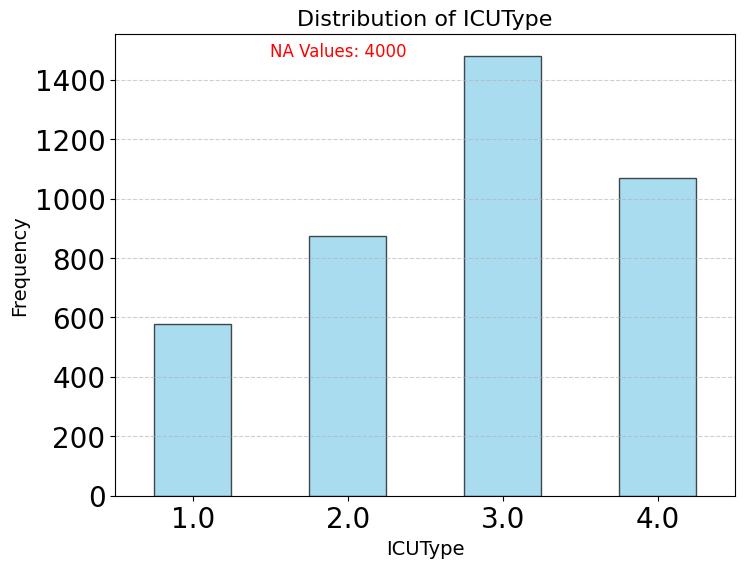

In [10]:
# Example DataFrame
# Assuming your data includes RecordID and ICUType columns
# df = pd.read_csv("your_data.csv") # Load your dataset here

# Keep only the first value of ICUType for each RecordID, including NA values
df_first = df[df['ICUType'].notna()].drop_duplicates(subset=["RecordID"], keep="first")

# To ensure that NA values are kept, concatenate back the rows where ICUType is NA
df_na = df[df["ICUType"].isna()].drop_duplicates(subset=["RecordID"], keep="first")
df_first = pd.concat([df_first, df_na], ignore_index=True)

# Count NA values in the ICUType column
na_count = df_first["ICUType"].isna().sum()

# Create the histogram
plt.figure(figsize=(8, 6))
df_first["ICUType"].value_counts().sort_index().plot(kind="bar", color="skyblue", alpha=0.7, edgecolor="black")

# Annotate the number of NA values on the plot
plt.text(0.5, 0.95 * plt.gca().get_ylim()[1], f"NA Values: {na_count}", fontsize=12, color="red")

# Formatting
plt.title("Distribution of ICUType", fontsize=16)
plt.xlabel("ICUType", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

/tmp/ipykernel_133830/4046387771.py:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/4046387771.py:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/4046387771.py:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,
/tmp/ipykernel_133830/4046387771.py:51: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=subset, x=column, ax=ax,


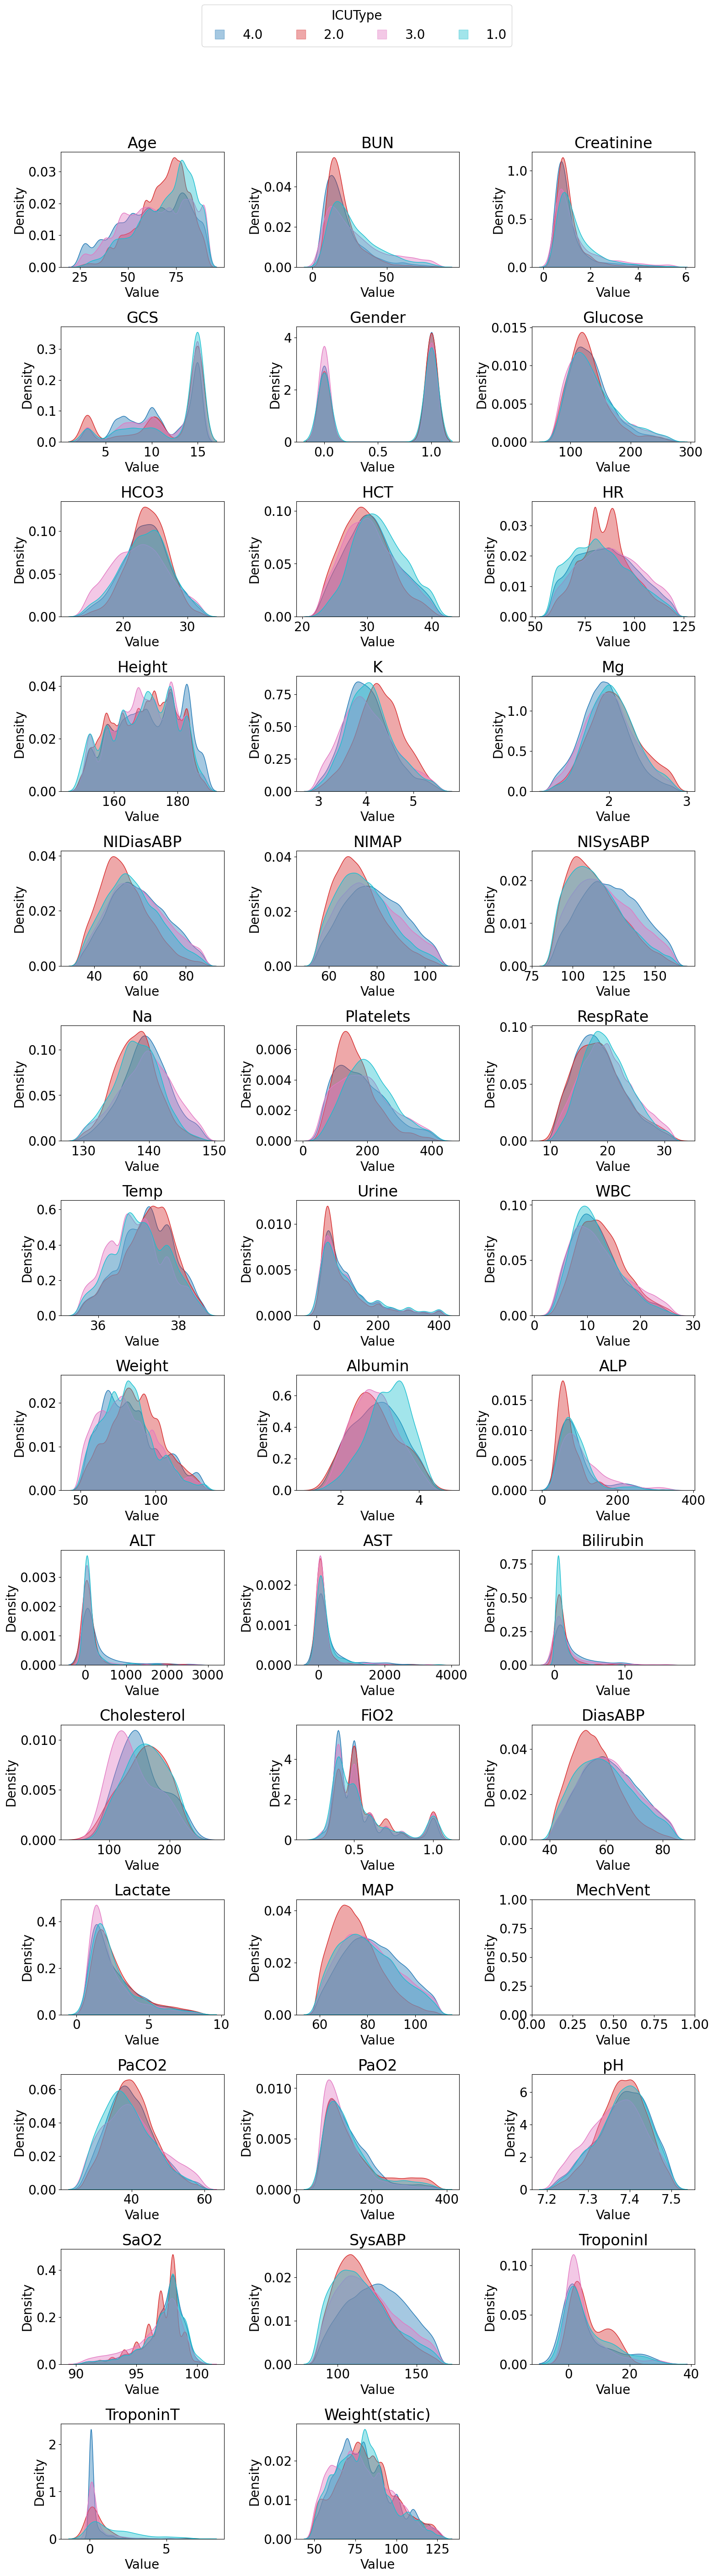

In [11]:
# Step 1: Forward fill the ICUType column
df["ICUType"] = df["ICUType"].ffill()

# Step 2: Drop unwanted columns
df_numerical = df.drop(columns=["RecordID", "Time"])

# Step 3: Remove outliers
percentiles = df_numerical.quantile([0.01, 0.99])
for column in df_numerical.columns:
    if column != "ICUType":  # Do not process ICUType as it is categorical
        lower_bound = percentiles.loc[0.01, column]
        upper_bound = percentiles.loc[0.99, column]
        df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), other=np.nan)

# Step 4: Setting up subplots for density plots grouped by ICUType
n_cols = 3  # Number of columns per row in the mosaic
n_features = len([col for col in df_numerical.columns if col != "ICUType"])  # Count numerical columns
n_rows = max(1, int(np.ceil(n_features / n_cols)))  # Ensure at least 1 row

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharex=False, sharey=False)
axes = axes.flatten()

plot_index = 0

# Retrieve unique ICUType values
icu_types = df["ICUType"].dropna().unique()  # Avoid dropping rows with no ICUType
colors = plt.cm.tab10(np.linspace(0, 1, len(icu_types)))
custom_lines = []
custom_labels = []

for column in df_numerical.columns:
    if column != "ICUType":  # Avoid plotting the categorical column itself
        ax = axes[plot_index]
        
        # Plot each ICUType group with consistent colors
        for i, icu_type in enumerate(icu_types):
            subset = df[df["ICUType"] == icu_type]
            
            # Only add to the custom legend elements on the first plot
            if plot_index == 0:
                # Create a color patch for the legend
                patch = plt.Line2D([0], [0], color=colors[i], lw=0, 
                                   marker='s', markersize=15, 
                                   markerfacecolor=colors[i], alpha=0.4)
                custom_lines.append(patch)
                custom_labels.append(str(icu_type))  # Ensure ICUType is a string for the legend
            
            # Only plot if subset has data
            if not subset.empty:
                sns.kdeplot(data=subset, x=column, ax=ax, 
                            color=colors[i], label=str(icu_type), 
                            fill=True, alpha=0.4)
        
        ax.set_title(column)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        
        # Remove individual legends
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        
        plot_index += 1

# Remove unused subplots
for j in range(plot_index, len(axes)):
    fig.delaxes(axes[j])

# First apply tight layout to optimize the plot spacing
plt.tight_layout()

# Add a single legend outside the plot
fig.legend(custom_lines, custom_labels, 
           title="ICUType",
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.01),
           ncol=len(custom_labels),
           frameon=True)

# Adjust top margin - reduce this value to bring legend closer to plots
plt.subplots_adjust(top=0.95)

plt.show()